#### Libraries

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.stats import norm
from scipy.optimize import minimize

#### Multivariate Gaussian

##### Loading Files

In [2]:
# load anomaly
anomaly1 = loadmat('anomaly1.mat')
anomaly2 = loadmat('anomaly2.mat')

# load anomaly 1
x1 = anomaly1['X']
x1_val = anomaly1['Xval']
y1_val = anomaly1['yval']

# load anomaly 1
x2 = anomaly2['X']
x2_val = anomaly2['Xval']
y2_val = anomaly2['yval']

##### Latency vs Transfer Rate Plot

In [3]:
def plot(x, xlim, ylim):
    plt.scatter(x[:, 0], x[:, 1], marker='.')
    plt.xlabel('Latency (ms)')
    plt.ylabel('Transfer Rate (mb/s)')
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.show()

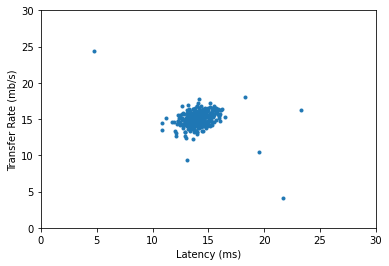

In [4]:
plot(x1, (0, 30), (0, 30))

##### Multivariate Gaussian

In [5]:
def estimate_gaussian(x):
    m = x.shape[0]
    mu = 1 / m * np.sum(x, axis=0)
    var = 1 / m * np.sum((x - mu) ** 2, axis=0)
    return mu, var

In [6]:
def multivariate_gaussian(x, mu, sigma2):
    k = len(mu)
    x = x - mu.T
    sigma2 = np.diag(sigma2)
    p = 1 / ((((2 * np.pi) ** k) * np.linalg.det(sigma2)) ** 0.5)
    p = p * np.exp(-0.5 * np.sum(x @ np.linalg.pinv(sigma2) * x, axis=1))
    return p

In [7]:
mu, sigma2 = estimate_gaussian(x1)

##### Gaussian Countour Plot

In [8]:
def plot_contour(mu, sigma2, x, xlim, ylim):
    # create a grid
    Xi = np.arange(*xlim, 0.1)
    Yi = np.arange(*ylim, 0.1)
    X, Y = np.meshgrid(Xi, Yi)
    # calculate probabilities
    Z = np.vstack((X.ravel(), Y.ravel())).T
    Z = multivariate_gaussian(Z, mu, sigma2)
    Z = Z.reshape(X.shape)
    # rescale probabilities
    Z = - np.log(Z)
    # plot contour curves 
    fig, ax = plt.subplots()
    CS = ax.contour(X, Y, Z, 12)
    ax.scatter(x[:, 0], x[:, 1], marker='.')
    ax.set_xlabel('Latency (ms)')
    ax.set_ylabel('Transfer Rate (mb/s)')
    ax.set_xlim(0, 30)
    ax.set_ylim(0, 30)
    plt.show()

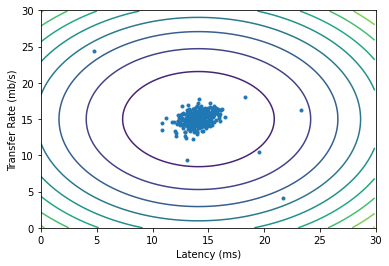

In [9]:
plot_contour(mu, sigma2, x1, (0, 30), (0, 30))

##### Select Best Threshold

In [10]:
def select_threshold(y, p):
    best_f1 = 0
    best_epi = 0

    epsilon = 10 ** -8
    stepsize = (p.max() - p.min()) / 1000
    epi_range = np.arange(p.min(), p.max(), stepsize)

    for epi in epi_range:
        predictions = (p < epi)[:, np.newaxis]
        tp = np.sum(predictions[y == 1] == 1)
        fp = np.sum(predictions[y == 0] == 1)
        fn = np.sum(predictions[y == 1] == 0)

        prec = tp / (tp + fp + epsilon)
        rec = tp / (tp + fn + epsilon)
        f1 = (2.0 * prec * rec) / (prec + rec + epsilon)
    
        if f1 > best_f1:
            best_f1 = f1
            best_epi = epi
      
    return best_f1, best_epi

In [11]:
prob = multivariate_gaussian(x1_val, mu, sigma2)
f1, epsilon = select_threshold(y1_val, prob)

print(f'Best F1: {f1:.8f}')
print(f'Best Epsilon: {epsilon}')

Best F1: 0.87499999
Best Epsilon: 8.990852779269493e-05


##### Anomaly Visualization

In [12]:
def plot_anomaly(x, prob, epsilon, xlim, ylim):
    # select anomaly points
    normal = [0 if p <= epsilon else 1 for p in prob]
    normal = np.array(normal, dtype=np.bool)
    anomaly = np.logical_not(normal)
    # plot anomaly points
    plt.scatter(x[normal, 0], x[normal, 1], marker='.')
    plt.scatter(x[anomaly, 0], x[anomaly, 1], marker='.')
    plt.legend(['Normal', 'Anomaly'])
    plt.xlabel('Latency (ms)')
    plt.ylabel('Transfer Rate (mb/s)')
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.show()

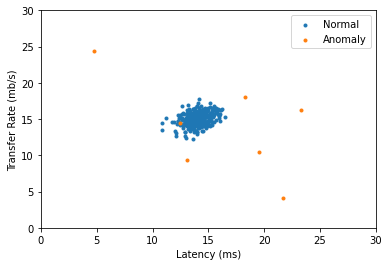

In [13]:
plot_anomaly(x1, prob, epsilon, (0, 30), (0, 30))

##### Anomaly Detection on `anomaly2.mat`

In [14]:
mu, sigma2 = estimate_gaussian(x2)

In [15]:
prob = multivariate_gaussian(x2_val, mu, sigma2)
f1, epsilon = select_threshold(y2_val, prob)

print(f'Best F1: {f1:.8f}')
print(f'Best Epsilon: {epsilon}')

Best F1: 0.61538461
Best Epsilon: 1.3772288907613575e-18


In [16]:
prob = multivariate_gaussian(x2, mu, sigma2)
n_anomalies = (prob <= epsilon).sum()

print(f'Number of Anomalies: {n_anomalies}')

Number of Anomalies: 117
